## HW2. Микросервисная архитектура

### Автор: *Кузнецов Кирилл Игоревич*
### Группа: М08-401НД
### Дата: __.10.2025

Это задание выполняется в рамках модуля 2 «Микросервисная архитектура». Вы разработаете монолит, затем будете разделять его на микросервисы.

> Чтобы получить максимальный балл, убедитесь, что ваш ноутбук запускается с нуля, все шаги сопровождаются выводом на печать в ячейках, структура понятна, а в выводах вы объясняете свои решения.  

## Подготовка окружения (работал на локальной машине так что устанавливал под миникондой + поправил команды для исполнения под ZSH и макос)

In [ ]:
# %%capture
# !brew install graphviz
# !pip install docker-compose-diagram
# !pip install fastapi 'uvicorn[standard]' -qq
# !pip install --upgrade sqlalchemy

---
### Задание 1
Создание и запуск веб-сервера на FastAPI

Задачи:
1. Создайте [main.py](http://main.py) с минимальным FastAPI-приложением и запустите его (uvicorn main:app --reload).
2. Параллельно откройте мониторинг процессов (top/htop или ps -ef | grep uvicorn) и зафиксируйте, что сервер работает в одном процессе (или в одном рабочем процессе при dev-запуске).
3. Подайте 1–2 тестовых запроса к разным эндпойнтам (например, /users, /orders), чтобы показать, что все обслуживается одним приложением.
4. Сделайте вывод, является ли это приложение монолитом, опираясь на признаки: один процесс, общее приложение, все эндпойнты работают внутри одного сервера. Опишите результат текстом.

>  Вам нужно вспомнить, что в модуле 2 называют монолитным приложением.

%%html
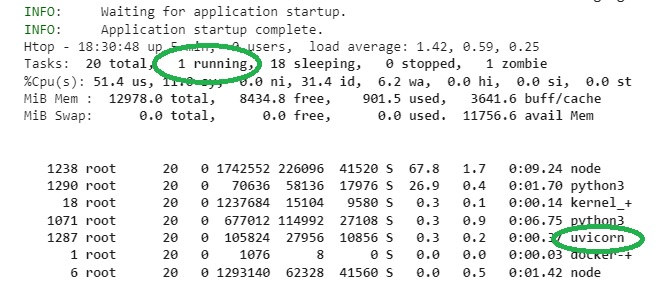

In [ ]:
%%writefile main.py

from fastapi import FastAPI
import uvicorn

app = FastAPI()

localdb=[{"name": "Иван Иванов", "email": "ivan@example.com"}]

@app.get("/info")
def info():
    return localdb[0]

Writing main.py


In [ ]:
print(f"Изучите список процессов операционной системы с помщью команды top")
!sleep 5 & uvicorn main:app --reload --port 8090 --host 0.0.0.0 & top & wait

Изучите список процессов операционной системы с помщью команды top
=INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8090 (Press CTRL+C to quit)
INFO:     Started reloader process [517] using WatchFiles
top - 16:28:32 up 1 min,  0 users,  load average: 1.09, 0.35, 0.13
Tasks:  21 total,   3 running,  17 sleeping,   0 stopped,   1 zombie
%Cpu(s): 46.7 us, 10.0 sy,  0.0 ni, 33.3 id,  6.7 wa,  0.0 hi,  3.3 si,  0.0 st
MiB Mem :  12978.0 total,   8309.6 free,    908.1 used,   3760.2 buff/cache
MiB Swap:      0.0 total,      0.0 free,      0.0 used.  11749.2 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND  
    517 root      20   0   38236  28076  10976 S  66.7   0.2   0:00.11 uvicorn  
    519 root      20   0   20040  11708   6460 R  13.3   0.1   0:00.02 python3  
    520 root      20   0   19816  11604   6400 R   6.7   0.1   0:00.01 python3  
      1 root      20   0    1076      8 

In [ ]:
""" ответ текстом """

___
### Задание 2

Есть монолитное веб-приложение (см. схему из конспекта). Четыре отдела генерируют нагрузку по 100 RPS каждый (суммарно ≈400 RPS), а текущая пропускная способность веб-сервера — ≈200 RPS; начинает ощущаться деградация. Для упрощения считаем, что сеть не узкое место, ресурсов RAM/CPU/HDD достаточно, техдолг низкий, финансовых ограничений нет.

Задача. Опишите в 5–8 предложениях ваш подход к декомпозиции монолита:
- Как вы диагностируете связность и выбираете границы сервисов (по доменам, бизнес-процессам или данным, допустим комбинированный вариант).
- Какие части вы вынесете первыми, чтобы снять узкое место по RPS, и почему.
- Как будете обеспечивать временную совместную работу старого и нового (этапный переход, strangler pattern).
- Кто владеет данными после разделения и как вы минимизируете риски согласованности.
- Нужен ли API-Gateway на входе и какие задачи он возьмет (маршрутизация, аутентификация, агрегация).

>  Вам нужно освежить раздел 4 «Что в монолите можно расделить на микросервисы»
 из модуля 2 и описать в 5—8 предложениях свой подход.

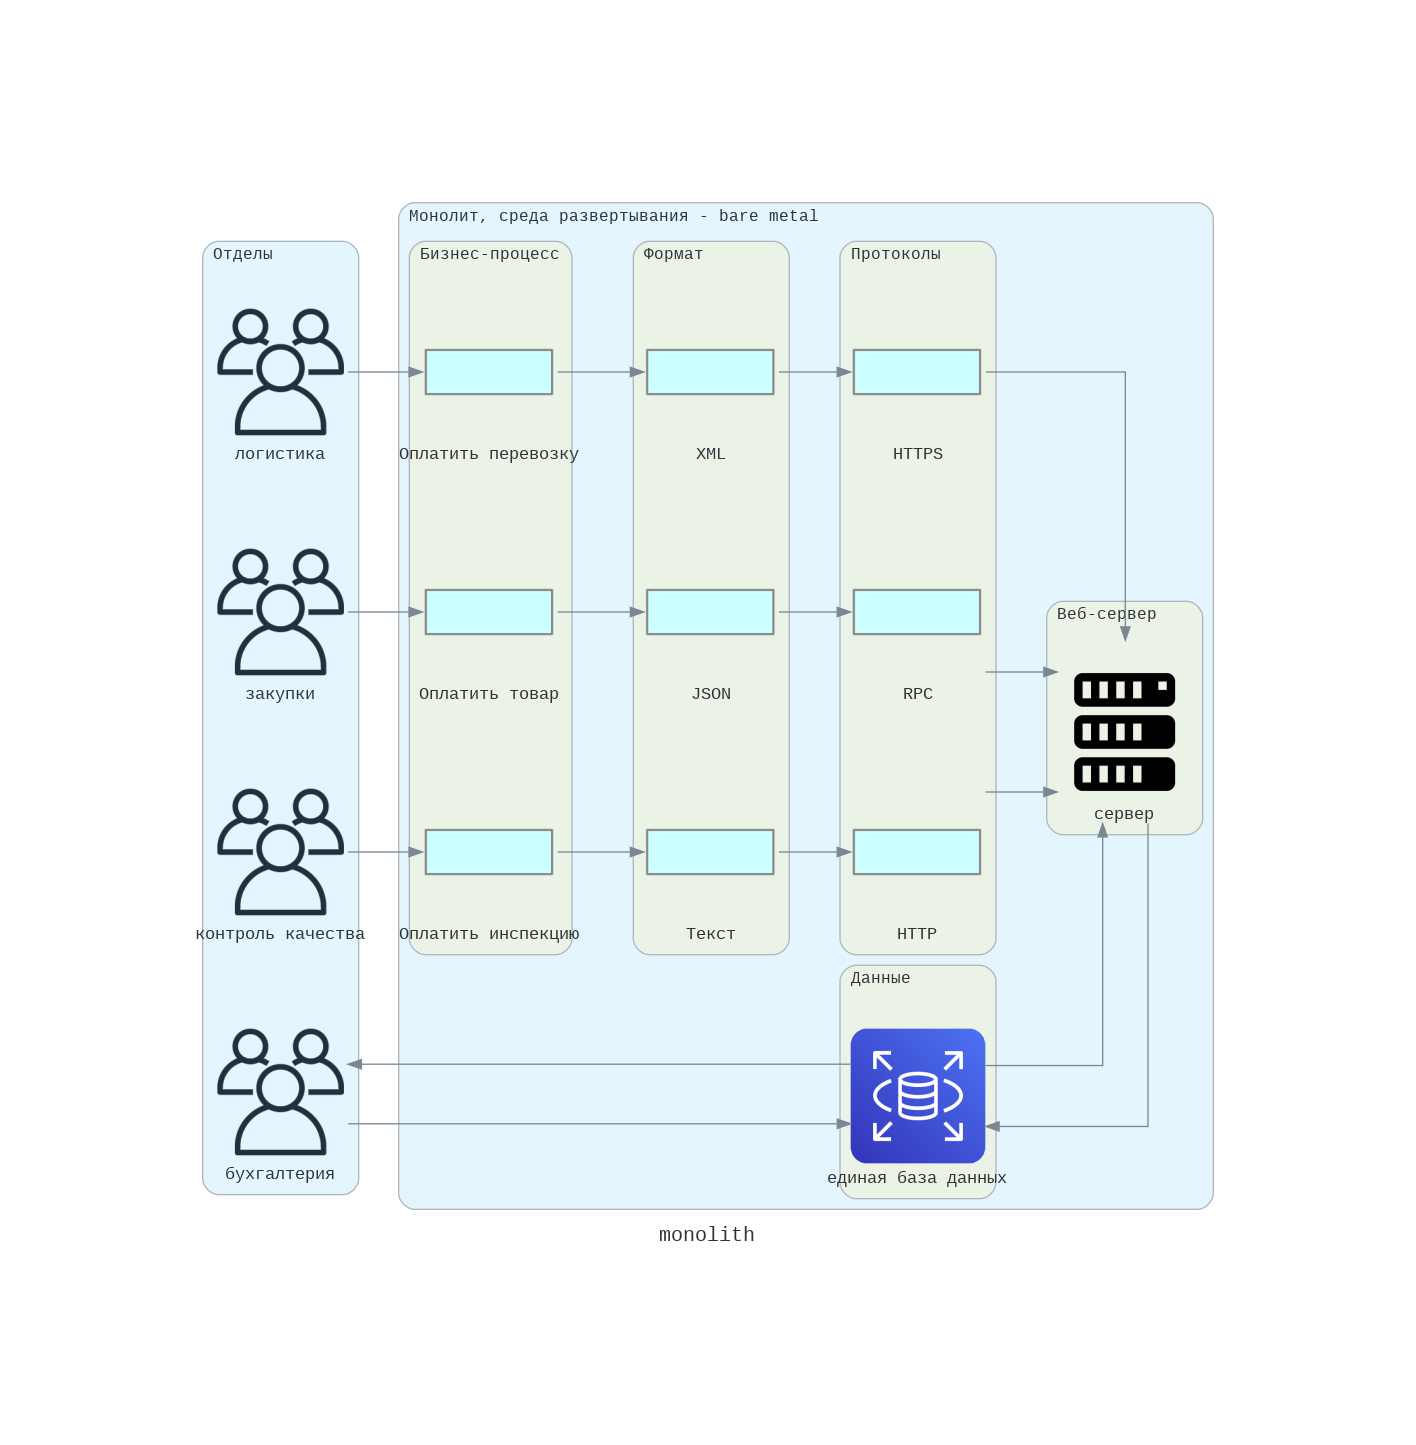

In [ ]:
from IPython.display import Image, display
with open("/content/diagram.py", "w") as f:
  f.write("""
from diagrams import Cluster, Diagram
from diagrams.onprem.compute import Server
from diagrams.aws.database import RDS
from diagrams.programming.flowchart import Action
from diagrams.onprem.client import Users

with Diagram("monolith", show=False):

    with Cluster("Отделы"):
        depts = [Users("логистика"),
                     Users("закупки"),
                     Users("контроль качества"),
                     Users("бухгалтерия")]

    with Cluster("Монолит, среда развертывания - bare metal"):
      with Cluster("Данные"):
        storage = [RDS("единая база данных")]

      with Cluster("Веб-сервер"):
        webserver = [Server("сервер")]

      with Cluster("Протоколы"):
        protocols = [Action("HTTPS"),
        Action("RPC"),
        Action("HTTP")]

      with Cluster("Формат"):
        formats = [Action("XML"),
        Action("JSON"),
        Action("Текст")]

      with Cluster("Бизнес-процесс"):
        process = [Action("Оплатить перевозку"),
        Action("Оплатить товар"),
        Action("Оплатить инспекцию")]

    storage[0] >> webserver[0]
    webserver[0] >> storage[0]
    storage[0] >> depts[3]
    depts[3] >> storage[0]

    depts[0] >> process[0] >> formats[0] >> protocols[0] >> webserver[0]
    depts[1] >> process[1] >> formats[1] >> protocols[1] >> webserver[0]
    depts[2] >> process[2] >> formats[2] >> protocols[2] >> webserver[0]
  """)
!python diagram.py
image_path = '/content/monolith.png'
display(Image(filename=image_path))

In [ ]:
""" ответ текстом """

' ответ текстом '

___
### Задание 3


В исходном коде смешаны бизнес-логика и доступ к данным, из-за чего любое изменение приводит к «стрельбе из дробовика» — приходится править код во множестве мест. Наша цель — развести ответственность по слоям.   

Задачи:  

1. Скопируйте код из Задания 3 в новую часть ноутбука.  
2. Разделите проект на слои в духе DDD (рекомендуемая схема, но можно адаптировать под ваш код):
- domain/ — сущности, бизнес-правила (никаких импортов инфраструктуры);
- application/ — сценарии/сервисы приложения (координаторы действий, use-cases);
- infrastructure/ — хранилища, клиенты БД/HTTP, репозитории;
- api/ — HTTP-интерфейс (эндпоинты) или CLI.

Рекомендация: ≤5 слоев; больше — избыточно.

3. Разнесите файлы по слоям и оформите их отдельными ячейками в ноутбуке:

Вместо %%writefile main.py (который перезаписывает один файл) используйте понятные пути:
- %%writefile domain/models.py
- %%writefile application/services.py
- %%writefile infrastructure/repository_sqlalchemy.py
- %%writefile api/http.py
и т. п. Затем покажите «склейку» импортами в короткой ячейке запуска.

4. Опишите, как вы понимаете постепенную декомпозицию функционала через Strangler Fig и зачем нужны тесты при такой миграции (достаточно высокого уровня: риски параллельных версий, обратная совместимость, почему одних assert в рабочем коде недостаточно). Сошлитесь на раздел «Как?»/принципы декомпозиции из материалов модуля.  

Вопросы:
1) Объясните, как вы понимаете работу паттерна strangler fig по постепенной декомпозиции функционала?
2) В коде многократно используется команда assert. Как вы считаете, для чего следует писать юнит-тесты?
3) Гарантирует ли тестирование обратную совместимость функционала?

>  Вам нужно освежить раздел 4 «Как?» из модуля 2 и ответить в 5—8 предложениях

In [ ]:
import random
from fastapi import FastAPI
import uvicorn
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

app = FastAPI()

localdb=[{"name": "Иван Иванов", "email": "ivan@example.com"}]  #<- была некая старая база данных
engine = create_engine("sqlite:///:memory:", echo=False)        #<- стала некая новая база данных
Session = sessionmaker(bind=engine)
session = Session()

with session.begin():  # Transaction starts here
    session.execute(text("""
        CREATE TABLE users (
            id INTEGER PRIMARY KEY,
            name VARCHAR(255) NOT NULL,
            email VARCHAR(255)
        );
    """))
    session.execute(
        text("INSERT INTO users (name, email) VALUES (:name, :email)"),
        {"name": "Иван Иванов", "email": "ivan@example.com"}
    )
    result = session.execute(text(f"SELECT id, name, email FROM users WHERE id=1"))
    for row in result.fetchall():
      print(f"ID: {row.id}, Name: {row.name}, Email: {row.email}")
    print("*"*80)


@app.get("/v1/info")
def old_system(request: str):
    """Существующая старая система."""
    return localdb[0]

@app.get("/v2/info")
def new_system(request: int):
    """Проектируемая новая система."""
    result = session.execute(text(f"SELECT id, name, email FROM users WHERE id={request}")).fetchone()
    return {"name":result.name, "email": result.email}

def strangler_fig(request, switchover_percentage):
    """
    паттерн "strangler_fig".

    Аргументы:
        request: Входные данные для обработки (было request: str -> стало request: int)
        switchover_percentage: Процент запросов, которые должны быть обработаны новой системой (0-100).
    """
    if random.randint(0, 100) < switchover_percentage:          # в реальности здесь более сложная проверка
        return new_system(int(request))
    else:
        return old_system(str(request))

if __name__ == "__main__":
    request_data = "1"
    current_percentage = 1                                      # Начинаем с 1% запросов, направляемых в новую систему

    result = strangler_fig(request_data, current_percentage)
    print(f"было : {result}")
    assert localdb[0] == result

    current_percentage = 70                                     # Постепенно увеличиваем процент
    result = strangler_fig(request_data, current_percentage)
    print(f"стало : {result}")
    assert localdb[0] == result

    current_percentage = 100                                    # В конечном итоге все запросы направляются в новую систему
    result = strangler_fig(request_data, current_percentage)
    print(f"стало : {result}")
    assert localdb[0] == result

ID: 1, Name: Иван Иванов, Email: ivan@example.com
********************************************************************************
было : {'name': 'Иван Иванов', 'email': 'ivan@example.com'}
стало : {'name': 'Иван Иванов', 'email': 'ivan@example.com'}
стало : {'name': 'Иван Иванов', 'email': 'ivan@example.com'}


In [ ]:
""" ответ текстом """

' ответ текстом '

___
### Задание 4

При переходе от монолита к микросервисам часто используют паттерн Strangler Fig. Его идея в том, что старое приложение не выбрасывается сразу, а постепенно «обрастает» новыми сервисами. Сначала часть запросов обрабатывает новый код, а часть — старый монолит.

Код из Задания 3 рабочий, но неправильно спроектирован: в слой бизнес-логики попал код из слоя хранения данных.

Задачи:  
1. Скопируйте код из Задания 3 в новую ячейку.
2. Проведите рефакторинг кода, разделяя его по слоям в соответствии с концепцией DDD (отдельно domain, application, infrastructure).
3. Реализуйте паттерн Strangler Fig для реальных HTTP-запросов.

___
### Задание 5

Задача: определите функцию (только def, без вызова), которая реализует паттерн Strangler Fig.

Требования:

1. функция должна обращаться как к новой системе, так и к старому монолиту по HTTP-запросам;
2. используйте requests.get (или, если умеете, современный асинхронный httpx).
3. код из Задания 3 работает на той же машине, что и веб-приложение — это неправильно. В новой версии предполагается, что API Gateway находится отдельно и делает HTTP-запросы.

In [ ]:
def strangler_fig(request, switchover_percentage):
    """
    паттерн "strangler_fig".

    Аргументы:
        request: Входные данные для обработки (было request: str -> стало request: int)
        switchover_percentage: Процент запросов, которые должны быть обработаны новой системой (0-100).
    """
    if random.randint(0, 100) < switchover_percentage:
        return new_system(int(request))                   # пусть адрес новой системы URL="http://172.0.0.1:8000"
    else:
        return old_system(str(request))                   # пусть адрес старой системы URL="http://127.0.0.1:8000"

___
## Задание 6

Подготовьте ноутбук в логичной структуре: написание кода → запуск кода → текстовые ответы в ячейках """ ответ текстом """ в 5—8 предложениях→ итоги.

В итоговых выводах сформулируйте 5–8 предложений со своим опытом (от полной поддержки монолита до неприятия монолита, от полной поддержки микросервисов до категорического неприятия).

Вопросы, на которые надо ответить по итогу:
- Когда стоит использовать монолит?
- Когда стоит использовать микросервисы?
- Когда и как стоит использовать гибридный подход?
